**Author**: Zidong Chen

**Introduction:** This notebook demonstrates how to implement svgp with mini-batch gradient descent, for detailed mathematical background, please refer to **GPTutorial_svgp**.

In [1]:
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  # Fixing strange error if run in MacOS
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from core.kernel import ARDKernel
import core.GP_CommonCalculation as GP

# Constants
JITTER = 1e-3
PI = 3.1415
torch.manual_seed(4)


# Function to create and initialize model parameters
def create_model(X, Y, num_inducing):
    data = GP.XYdata_normalization(X, Y, 0)
    X_all, Y_all = data.normalize(X, Y)
    kernel = ARDKernel(1)

    xm = nn.Parameter(torch.rand(num_inducing, 1, dtype=torch.float64))  # Inducing points
    qu_mean = nn.Parameter(torch.zeros(num_inducing, 1, dtype=torch.float64))
    chole = nn.Parameter(torch.rand(num_inducing, 1, dtype=torch.float64))
    log_beta = nn.Parameter(torch.ones(1, dtype=torch.float64) * 0)

    return X_all, Y_all, kernel, xm, qu_mean, chole, log_beta

In [2]:
# Function to get a new batch of data
def new_batch(dataloader, iterator):
    try:
        X_batch, Y_batch = next(iterator)
    except StopIteration:
        iterator = iter(dataloader)
        X_batch, Y_batch = next(iterator)
    return X_batch, Y_batch, iterator

In [3]:
# Function to compute variational loss
def variational_loss(X, Y, xm, qu_mean, chole, log_beta, kernel):
    K_mm = kernel(xm, xm) + JITTER * torch.eye(xm.size(0), dtype=torch.float64)
    Lm = torch.linalg.cholesky(K_mm)
    K_mm_inv = torch.cholesky_inverse(Lm)
    K_mn = kernel(xm, X)
    K_nm = K_mn.t()
    qu_S = chole @ chole.t() + JITTER * torch.eye(xm.size(0), dtype=torch.float64)
    Ls = torch.linalg.cholesky(qu_S)
    K_nn = kernel(X, X).diag()
    batch_size = X.size(0)
    mean_vector = K_nm @ K_mm_inv @ qu_mean
    precision = 1 / log_beta.exp()
    K_tilde = precision * (K_nn - (K_nm @ K_mm_inv @ K_mn).diag())
    K_nm_expanded = K_nm.unsqueeze(2)
    K_nm_transposed = K_nm_expanded.transpose(1, 2)
    lambda_mat = torch.matmul(K_nm_expanded, K_nm_transposed)
    lambda_mat = K_mm_inv @ lambda_mat @ K_mm_inv
    batch_matrices = qu_S @ lambda_mat
    traces = precision * torch.einsum('bii->b', batch_matrices)

    likelihood_sum = -0.5 * batch_size * torch.log(2 * torch.tensor(PI)) + 0.5 * batch_size * torch.log(
        log_beta.exp()) - 0.5 * log_beta.exp() * ((Y - K_nm @ K_mm_inv @ qu_mean) ** 2).sum(dim=0).view(-1,
                                                                                                        1) - 0.5 * torch.sum(
        K_tilde) - 0.5 * torch.sum(traces)

    logdetS = 2 * Ls.diag().abs().log().sum()
    logdetKmm = 2 * Lm.diag().abs().log().sum()
    KL = 0.5 * (K_mm_inv @ qu_S).diag().sum(dim=0).view(-1, 1) + 0.5 * (
                qu_mean.t() @ K_mm_inv @ qu_mean) - 0.5 * logdetS + 0.5 * logdetKmm - 0.5 * xm.size(0)
    return likelihood_sum, KL, mean_vector

In [4]:
# Function to evaluate the model
def forward(Xte, xm, qu_mean, chole, kernel):
    K_mm = kernel(xm, xm) + JITTER * torch.eye(xm.size(0), dtype=torch.float64)
    Lm = torch.linalg.cholesky(K_mm)
    K_mm_inv = torch.cholesky_inverse(Lm)
    K_tt = kernel(Xte, Xte)
    K_tm = kernel(Xte, xm)
    K_mt = K_tm.t()
    A = K_tm @ K_mm_inv
    mean = A @ qu_mean
    yvar = K_tt - K_tm @ K_mm_inv @ K_mt + K_tm @ K_mm_inv @ (chole @ chole.t()) @ K_mm_inv @ K_mt
    yvar = yvar.diag().view(-1, 1)
    return mean, yvar

In [5]:
# Initialize training and test data
torch.manual_seed(4)
num_data = 3000
xtr = torch.rand(num_data, 1, dtype=torch.float64)
ytr = ((6 * xtr - 2) ** 2) * torch.sin(12 * xtr - 4) + torch.randn(num_data, 1, dtype=torch.float64) * 0.1
xte = torch.linspace(0, 1, 1000, dtype=torch.float64).view(-1, 1)
yte = ((6 * xte - 2) ** 2) * torch.sin(12 * xte - 4)
normalizer = GP.XYdata_normalization(xtr, ytr, 0)
x_normalized, y_normalized = normalizer.normalize(xtr, ytr)
xte_normalized = normalizer.normalize(xte)

In [8]:
# Model parameters
num_inducing = 30
batch_size = 300
learning_rate = 0.1
num_epochs = 500

# Create model
X_all, Y_all, kernel, xm, qu_mean, chole, log_beta = create_model(x_normalized, y_normalized, num_inducing)
dataset = TensorDataset(X_all, Y_all)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
iterator = iter(dataloader)
optimizer = torch.optim.Adam(list(kernel.parameters()) + [xm, qu_mean, chole, log_beta], lr=learning_rate)

# Training loop
for i in range(num_epochs):
    optimizer.zero_grad()
    X_batch, Y_batch, iterator = new_batch(dataloader, iterator)
    likelihood, KL, _ = variational_loss(X_batch, Y_batch, xm, qu_mean, chole, log_beta, kernel)
    loss = KL - likelihood * num_data / batch_size  # Negative ELBO
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        print('iter', i, 'nll:{:.5f}'.format(loss.item()))

iter 0 nll:11261.28431
iter 10 nll:3788.13356
iter 20 nll:2071.20391
iter 30 nll:1105.66341
iter 40 nll:335.36690
iter 50 nll:-624.96804
iter 60 nll:-1459.26663
iter 70 nll:1959.88205
iter 80 nll:1030.93355
iter 90 nll:-1662.94451
iter 100 nll:-2874.14010
iter 110 nll:-3797.08773
iter 120 nll:-4545.88211
iter 130 nll:-2173.18716
iter 140 nll:-3804.93081
iter 150 nll:-5278.90290
iter 160 nll:-5193.31798
iter 170 nll:-4401.82172
iter 180 nll:-4683.39436
iter 190 nll:-5413.47460
iter 200 nll:-2906.71786
iter 210 nll:-2730.00531
iter 220 nll:-3822.84533
iter 230 nll:-4619.96322
iter 240 nll:-5225.92466
iter 250 nll:-5951.93737
iter 260 nll:-6179.13395
iter 270 nll:798.62089
iter 280 nll:-2657.00812
iter 290 nll:-3321.65606
iter 300 nll:-3779.87198
iter 310 nll:-4356.22248
iter 320 nll:-5024.63947
iter 330 nll:-5751.41581
iter 340 nll:5037.33958
iter 350 nll:-533.69222
iter 360 nll:-1195.06444
iter 370 nll:-2110.08541
iter 380 nll:-2677.72624
iter 390 nll:-3259.06101
iter 400 nll:-3927.0761

Test MSE: 12.179613219575403


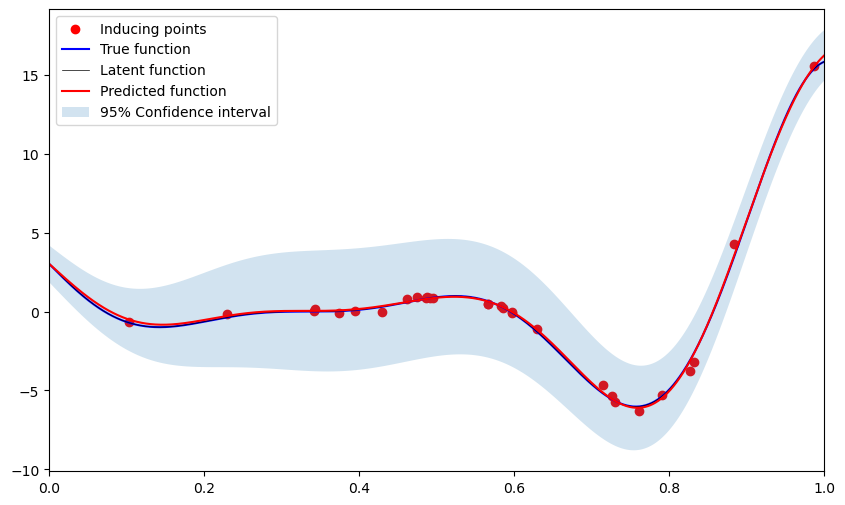

In [9]:
# Evaluate the model
with torch.no_grad():
    predictions, yvar = forward(xte_normalized, xm, qu_mean, chole, kernel)
    xm_denormalized, qu_mean_denormalized = normalizer.denormalize(xm, qu_mean)
    ypred, yvar = normalizer.denormalize_y(predictions, yvar)
    mse = torch.mean((predictions - yte) ** 2)
    print(f'Test MSE: {mse.item()}')

# Plotting results
plt.figure(figsize=(10, 6))
plt.scatter(xm_denormalized, qu_mean_denormalized, color='r', label='Inducing points')
plt.plot(xte.numpy(), yte.numpy(), 'b', label='True function')
#Latent function
plt.plot(xte.numpy(), yte.numpy(), label='Latent function', c='k', lw=0.5)
plt.plot(xte.numpy(), ypred.numpy(), 'r', label='Predicted function')
plt.fill_between(xte.squeeze().numpy(),
                 ypred.squeeze().detach().numpy() - 1.96 * np.sqrt(yvar.squeeze().detach().numpy()),
                 ypred.squeeze().detach().numpy() + 1.96 * np.sqrt(yvar.squeeze().detach().numpy()), alpha=0.2,
                 label='95% Confidence interval')
plt.xlim(0, 1)
plt.legend()
plt.show()